In [1]:
import requests
import yfinance as yf
import pandas as pd
import numpy as np
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima import auto_arima

# 발급받은 인코딩된 서비스키를 사용하세요.
service_key = 'mUglWToAvQmeYwqfOR1UwESkdwoUdkYmZTS5lWDf5pEGuh1gvgyfIy%2BtFKzTNsFYqE%2BM0a6NlwJGtxyhBV63sQ%3D%3D'

def get_stock_code(stock_name):
    """종목명을 입력받아 종목 번호 조회"""
    url = f"https://apis.data.go.kr/1160100/service/GetStockSecuritiesInfoService/getStockPriceInfo?serviceKey={service_key}&numOfRows=1&pageNo=1&resultType=json&itmsNm={stock_name}"
    response = requests.get(url)
    
    if response.status_code == 200:
        data = response.json()
        items = data.get('response', {}).get('body', {}).get('items', {}).get('item', [])
        
        if items:
            # 종목 코드 추출
            stock_code = items[0].get('srtnCd', '')  # 짧은 종목 코드 가져오기
            market_type = items[0].get('mrktCtg', '')  # 시장 구분 (KOSPI/KOSDAQ)
            
            # yfinance 형식으로 변환
            suffix = '.KS' if market_type == 'KOSPI' else '.KQ'
            return f"{stock_code}{suffix}"
        else:
            print("해당 종목명을 찾을 수 없습니다.")
            return None
    else:
        print(f"API 호출 실패: {response.status_code}")
        return None

In [2]:
def get_stock_data(stock_name, period='5y', interval='monthly'):
    """종목명으로 yfinance 데이터를 불러오기"""
    ticker = get_stock_code(stock_name)
    if ticker is None:
        return None

    # yfinance로 주식 데이터 불러오기
    stock = yf.Ticker(ticker)
    df = stock.history(period=period)

    # 원하는 데이터 재구성
#     if interval == 'weekly':  # 주 단위 데이터
#         df_resampled = df['Close'].resample('W-MON').last().reset_index()
    if interval == 'monthly':  # 월말 데이터
        df_resampled = df['Close'].resample('M').last().reset_index()
    elif interval == 'semi_monthly':  # 월중(15일) 및 월말 데이터
        # 날짜에서 필요한 정보 추출
        df = df.reset_index()  # 인덱스를 초기화하여 `Date` 열로 변환
        df['Day'] = df['Date'].dt.day
        df['Month'] = df['Date'].dt.month
        df['Year'] = df['Date'].dt.year

        # 월말 데이터: 각 달의 마지막 날짜
        df['Month_End'] = df['Date'] == df.groupby(['Year', 'Month'])['Date'].transform('max')
        
        # 월중(15일) 데이터와 월말 데이터 필터링
        mid_month_data = df[df['Day'] == 15]  # 월중 (15일)
        end_month_data = df[df['Month_End']]  # 월말 데이터
        
        # 월중 및 월말 데이터를 병합
        df_resampled = pd.concat([mid_month_data, end_month_data]).sort_values('Date').reset_index(drop=True)
    else:
        raise ValueError("지원되지 않는 interval 값입니다. 'weekly', 'monthly', 'semi_monthly' 중 하나를 선택하세요.")

    # 필요한 열만 반환
    return df_resampled[['Date', 'Close']]

def cal_increase(stock_name, interval):
    if interval == 'monthly':
        df_monthly = get_stock_data(stock_name, interval='monthly')
        df_monthly['Increase'] = df_monthly['Close'].diff()
        df_monthly = df_monthly.dropna().reset_index(drop=True)
        return df_monthly
    elif interval == 'semi_monthly':
        df_semi_monthly = get_stock_data(stock_name, interval='semi_monthly')
        df_semi_monthly['Increase'] = df_semi_monthly['Close'].diff()
        df_semi_monthly = df_semi_monthly.dropna().reset_index(drop=True)
        return df_semi_monthly

In [3]:
def cal_data(stock_name, interval='monthly'):
    """
    주어진 종목 데이터를 기반으로 월별 또는 월중(15일) 및 월말 통계량 계산.
    
    Parameters:
    - stock_name: str, 종목 이름
    - interval: str, 데이터 주기 ('monthly', 'semi_monthly')
    
    Returns:
    - DataFrame: 통계량이 포함된 결과 데이터프레임
    """
    if interval == 'monthly':
        df_monthly = cal_increase(stock_name, interval='monthly')
        monthly_increase_data = df_monthly['Increase']
        monthly_mean = monthly_increase_data.mean()                  # 평균    
        monthly_std = monthly_increase_data.std()                    # 표준편차 
        monthly_lower_bound = monthly_mean - 1.96 * monthly_std      # 하한
        monthly_upper_bound = monthly_mean + 1.96 * monthly_std      # 상한
        df_monthly['Increase'] = df_monthly['Increase'].clip(lower=monthly_lower_bound, upper=monthly_upper_bound)
        
        # 전체 데이터를 월별로 그룹화하여 통계량 계산
        df_monthly['Month'] = df_monthly['Date'].dt.month
        monthly_stats = df_monthly.groupby('Month')['Increase'].agg(
            Max='max',          # 최대 증가량
            Min='min',          # 최소 증가량
            Median='median',    # 증가량 중앙값
            Mean='mean',        # 증가량 평균
            Std='std',          # 표준편차
            Variance='var',     # 분산
            Q1=lambda x: x.quantile(0.25),  # 1사분위수 (25th Percentile)
            Q3=lambda x: x.quantile(0.75)   # 3사분위수 (75th Percentile)
        )

        # 양수인 증가량 개수 계산
        positive_counts = df_monthly[df_monthly['Increase'] > 0].groupby('Month')['Increase'].count()

        # 모든 월을 포함하여 결과 결합 및 누락 값 채우기
        monthly_stats = monthly_stats.join(positive_counts.rename('Increase Count')).reindex(range(1, 13), fill_value=0).reset_index()
        monthly_stats['Increase Count'] = monthly_stats['Increase Count'].fillna(0).astype(int)
        
        return monthly_stats

    elif interval == 'semi_monthly':
        df_semi_monthly = cal_increase(stock_name, interval='semi_monthly')
        semi_monthly_increase_data = df_semi_monthly['Increase']
        semi_monthly_mean = semi_monthly_increase_data.mean()
        semi_monthly_std = semi_monthly_increase_data.std()
        semi_monthly_lower_bound = semi_monthly_mean - 1.96 * semi_monthly_std
        semi_monthly_upper_bound = semi_monthly_mean + 1.96 * semi_monthly_std
        df_semi_monthly['Increase'] = df_semi_monthly['Increase'].clip(lower=semi_monthly_lower_bound, upper=semi_monthly_upper_bound)

        # 월중 및 월말 데이터 처리
        df_semi_monthly['Period'] = df_semi_monthly['Date'].dt.day.apply(
            lambda x: 'Mid' if x < 20 else 'End'
        )  # 15일 이전을 'Mid', 이후를 'End'로 구분

        df_semi_monthly['Month'] = df_semi_monthly['Date'].dt.month
        df_semi_monthly['Month-Period'] = df_semi_monthly['Month'].astype(str) + '-' + df_semi_monthly['Period']

        # 월-기간별 통계량 계산
        semi_monthly_stats = df_semi_monthly.groupby('Month-Period')['Increase'].agg(
            Max='max',          # 최대 증가량
            Min='min',          # 최소 증가량
            Median='median',    # 증가량 중앙값
            Mean='mean',        # 증가량 평균
            Std='std',          # 표준편차
            Variance='var',     # 분산
            Q1=lambda x: x.quantile(0.25),  # 1사분위수 (25th Percentile)
            Q3=lambda x: x.quantile(0.75)   # 3사분위수 (75th Percentile)
        )

        # 양수인 증가량 개수 계산
        positive_counts_semi = df_semi_monthly[df_semi_monthly['Increase'] > 0].groupby('Month-Period')['Increase'].count()

        # 결과 결합 및 누락 값 처리
        semi_monthly_stats = semi_monthly_stats.join(positive_counts_semi.rename('Increase Count')).fillna(0).reset_index()
        semi_monthly_stats['Increase Count'] = semi_monthly_stats['Increase Count'].astype(int)

        # Month-Period 순서 정렬
        # Mid=1, End=2로 변환하여 Month, Period 기준으로 정렬
        semi_monthly_stats['Sort_Key'] = semi_monthly_stats['Month-Period'].apply(
            lambda x: (int(x.split('-')[0]), 1 if x.split('-')[1] == 'Mid' else 2)
        )

        # 정렬 후 정렬 키 삭제
        semi_monthly_stats = semi_monthly_stats.sort_values('Sort_Key').drop(columns=['Sort_Key']).reset_index(drop=True)
        
        return semi_monthly_stats

In [4]:
monthly_stats = cal_data("SK하이닉스", 'monthly')
monthly_stats

,Month,Max,Min,Median,Mean,Std,Variance,Q1,Q3,Increase Count
0,1,13294.101562,-10203.640625,-570.164062,-81.690625,9242.619089,8.542601e+07,-6768.906250,3840.156250,2
1,2,21401.687500,-5321.757812,2429.429688,7527.275000,11645.452698,1.356166e+08,886.273438,18240.742188,4
2,3,26979.531250,-8640.359375,-4371.445312,1782.135937,14378.062945,2.067287e+08,-4571.500000,-485.546875,1
3,4,889.343750,-8774.281250,-4320.179688,-3436.634375,4069.552261,1.656126e+07,-5358.164062,380.109375,2
4,5,18873.851562,-4383.945312,-960.023438,5279.076563,10782.829332,1.162694e+08,-2090.671875,14956.171875,2
5,6,27253.885401,-16281.640625,3421.132812,4338.966143,15590.057162,2.430499e+08,480.015625,6821.437500,4
6,7,8124.234375,-23849.531234,-2185.726562,-5113.664059,13799.294161,1.904205e+08,-14400.593750,6743.296875,2
7,8,-1585.218750,-20865.343750,-5760.218750,-7633.378125,7749.526356,6.005516e+07,-7317.421875,-2638.687500,0
8,9,8457.789062,-11524.023438,-3360.140625,-2396.114062,7645.105901,5.844764e+07,-6742.257812,1188.062500,2
9,10,11700.000000,-3896.281250,0.000000,1800.126563,5885.331920,3.463713e+07,-392.375000,1589.289062,2


In [5]:
semi_monthly_stats = cal_data("SK하이닉스", 'semi_monthly')
semi_monthly_stats

,Month-Period,Max,Min,Median,Mean,Std,Variance,Q1,Q3,Increase Count
0,1-Mid,8640.351562,-7366.171875,3896.273438,1723.484375,8221.493622,6.759296e+07,-1734.949219,6268.312500,2
1,1-End,13294.109375,-10203.632812,-4466.460938,-1115.782813,8915.863458,7.949262e+07,-4800.195312,597.265625,2
2,2-Mid,14135.062500,3151.187500,7718.449219,8180.787109,4658.630997,2.170284e+07,5525.195312,10374.041016,4
3,2-End,9120.375000,-5321.750000,-2264.921875,982.643750,6702.940563,4.492941e+07,-3887.109375,7266.625000,2
4,3-Mid,4977.125000,-10142.906250,-5801.316406,-4192.103516,6497.956860,4.222344e+07,-7637.537109,-2355.882812,1
5,3-End,20486.652408,-4371.468750,2230.937500,4832.669544,10428.656236,1.087569e+08,-3840.132812,9657.359375,3
6,4-Mid,5184.812500,-9742.125000,4800.179688,80.955729,8509.211001,7.240667e+07,-2470.972656,4992.496094,2
7,4-End,4383.953125,-13959.093750,380.140625,-3485.201562,7704.845908,5.936465e+07,-9120.359375,889.351562,3
8,5-Mid,-1710.562500,-3063.296875,-2386.929688,-2386.929688,956.527650,9.149451e+05,-2725.113281,-2048.746094,0
9,5-End,20486.652408,-4383.953125,-380.125000,5943.741419,11034.433705,1.217587e+08,-960.039062,14956.171875,2


In [6]:
import matplotlib.pyplot as plt

def plot_stats_dual_axis(stats_df, interval):
    """
    통계 데이터를 이중 축으로 시각화.
    - 왼쪽 y축: Median (Increase)
    - 오른쪽 y축: Increase Count

    Parameters:
    - stats_df: DataFrame, 통계 데이터
    - interval: str, 주기 ('monthly', 'semi_monthly')
    """
    # 그래프 크기 설정
    fig, ax1 = plt.subplots(figsize=(14, 7))

    # x축 데이터 설정
    x_labels = stats_df['Month'] if interval == 'monthly' else stats_df['Month-Period']
    
    # 왼쪽 y축: Median 꺾은선 그래프
    ax1.set_xlabel('Month' if interval == 'monthly' else 'Month-Period', fontsize=12)
    ax1.set_ylabel('Median (Increase)', fontsize=12, color='red')
    ax1.plot(x_labels, stats_df['Median'], marker='o', color='red', label='Median (Increase)', linewidth=2)
    ax1.tick_params(axis='y', labelcolor='black')
    ax1.grid(axis='y', linestyle='--', alpha=0.7)

    # 오른쪽 y축: Increase Count 막대 그래프
    ax2 = ax1.twinx()  # 공유된 x축을 사용하는 두 번째 y축 생성
    ax2.set_ylabel('Increase Count', fontsize=12, color='darkorange')
    ax2.bar(x_labels, stats_df['Increase Count'], alpha=0.6, label='Increase Count (Max=5)', width=0.4, color='darkorange')
    ax2.tick_params(axis='y', labelcolor='black')

    # 그래프 제목 및 x축 레이블 설정
    title = 'Monthly Statistics' if interval == 'monthly' else 'Semi-Monthly Statistics'
    plt.title(title, fontsize=16)
    plt.xticks(rotation=45, fontsize=10)

    # 레전드 추가
    ax1.legend(loc='upper left', fontsize=12)
    ax2.legend(loc='upper right', fontsize=12)

    # 그래프 출력
    plt.tight_layout()
    plt.show()

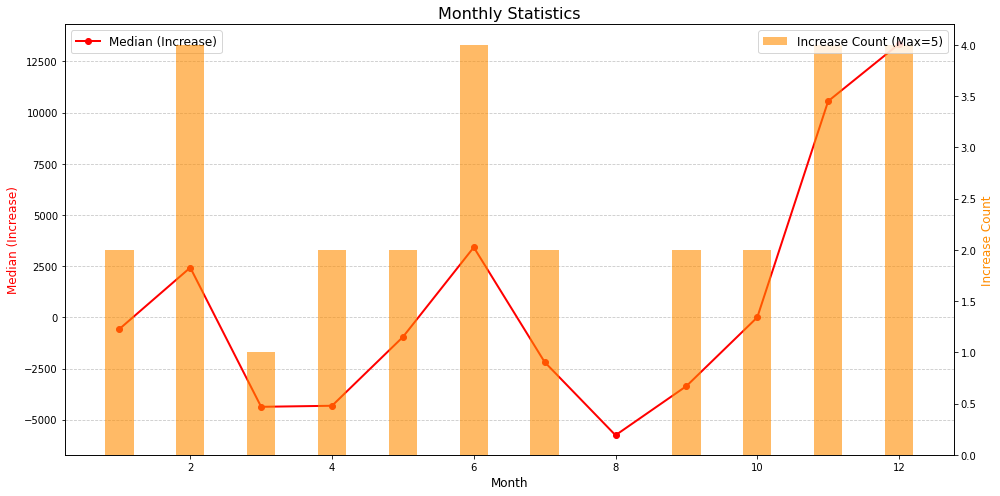

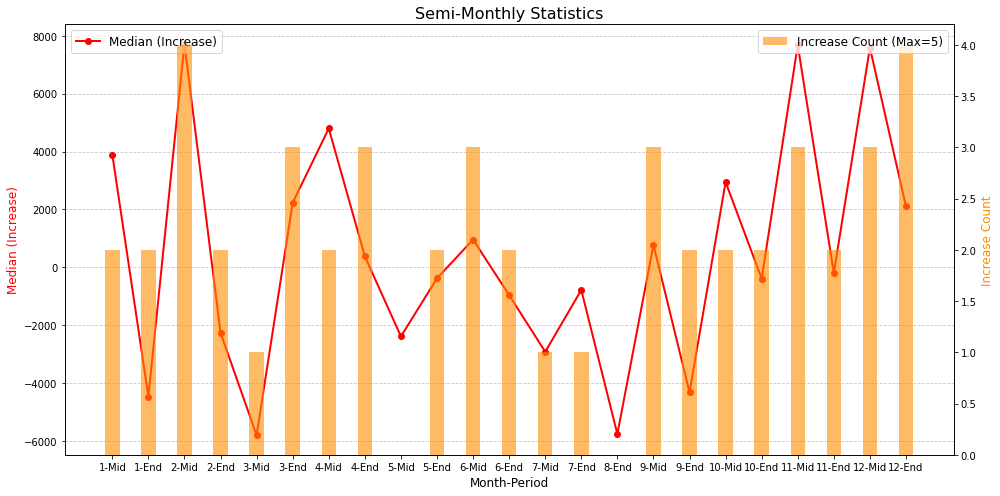

In [7]:
# 월별 데이터 시각화
plot_stats_dual_axis(monthly_stats, interval='monthly')

# 반월별 데이터 시각화
plot_stats_dual_axis(semi_monthly_stats, interval='semi_monthly')